In [1]:
import os
import shutil
import warnings

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

from train import create_net
from utils import transforms as MT
from utils.datasets import AortaDataset3DCenter
from utils.eval import eval_net

warnings.filterwarnings("ignore")
np.random.seed(63910)
torch.manual_seed(53152)
torch.cuda.manual_seed_all(7987)
torch.backends.cudnn.deterministic = True

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
n_channels, n_classes, batch_size = 1, 4, 128

transform = T.Compose([
    MT.Resize3D(81),
    MT.CenterCrop3D(81),
    MT.ToTensor3D(),
])

train = AortaDataset3DCenter('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/center/train/', transform=transform, depth=7)
val = AortaDataset3DCenter('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/center/val/', transform=transform, depth=7)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)

In [2]:
n_channels, n_classes, batch_size = 1, 4, 128

transform = T.Compose([
    T.Resize(81), # 缩放图片(Image)，保持长宽比不变，最短边为img_size像素
    T.CenterCrop(81), # 从图片中间切出img_size*img_size的图片
    T.ToTensor(), # 将图片(Image)转成Tensor，归一化至[0, 1]
])

train = ImageFolder('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/', transform=transform, loader=lambda path: Image.open(path))
val = ImageFolder('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/', transform=transform, loader=lambda path: Image.open(path))
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)

In [3]:
net = create_net(device, 'resnet', 34, n_channels, n_classes, '/nfs3-p2/zsxm/temp_path/single81.pth', entire=True, flag_3d=False)
net.eval()
print('')

[INFO]: **********************************************************************
Network: ResNet_34
	1 input channels
	4 output channels (classes)
	3D model: False

[INFO]: Model loaded from /nfs3-p2/zsxm/temp_path/single81.pth



In [ ]:
class HookModule:
    def __init__(self, model, module):
        self.model = model
        self.handle = module.register_forward_hook(self._get_output)
        
    def _get_output(self, module, inputs, outputs):
        self.outputs = outputs
    
    def grads(self, outputs, retain_graph=True, create_graph=True):
        grads = torch.autograd.grad(outputs=outputs, inputs=self.outputs, retain_graph=retain_graph, create_graph=create_graph)
        self.model.zero_grad()
        print(grads[0].shape)
        return grads[0]
    
    def remove(self):
        self.handle.remove()
        
hook = HookModule(net, net.encoder.layer4[2].conv1)

In [ ]:
hook.remove()

In [ ]:
def get_grads(dataset, dataloader, end=500, start=0):
    idx = 0
    score_list = [[] for _ in range(n_classes)]
    err_list = [[] for _ in range(n_classes)]
    for imgs, true_categories in tqdm(dataloader, total=len(dataloader), desc='Dataset', unit='batch', leave=False):
        imgs = imgs.to(device=device, dtype=torch.float32)
        true_categories = true_categories.to(device=device, dtype=torch.long)

        with torch.no_grad():
            categories_pred = torch.softmax(net(imgs), dim=1)
            labels_pred = categories_pred.argmax(dim=1)
            for i in range(len(true_categories)):
                if labels_pred[i] == true_categories[i]:
                    score_list[true_categories[i].item()].append((categories_pred[i, labels_pred[i]].item(), idx))
                else:
                    #err_list[true_categories[i].item()].append(dataset.samples[idx][0])
                    pass
                idx += 1
    
    grad_list = []
    mask_list = []
    for i in range(n_classes):
        print(len(score_list[i]))
        score_list[i].sort(key=lambda x: x[0], reverse=True)
        print(score_list[i][end-1])
        idx_list = [score[1] for score in score_list[i][start: end]]
        tensor_list = []
        for idx in idx_list:
            tensor_list.append(dataset[idx][0])
        batch = torch.stack(tensor_list, dim=0)
        pred = net(batch.to(device))
        nll_loss = F.nll_loss(pred, (torch.ones(batch.size(0))*i).to(device, dtype=torch.long))
        grads = hook.grads(-nll_loss, True, False)
        nll_loss.backward()
        grads = F.relu(grads).sum(dim=(2,3,4)).mean(dim=0)#grads.abs().sum(dim=(2,3,4)).mean(dim=0)
        #grads = F.relu(grads).sum(dim=(2,3)).mean(dim=0)
        print(grads.shape)
        grad_list.append(grads.cpu().numpy())
        mask = (grads>grads.mean()).long()
        mask_list.append(mask.cpu().numpy())

    grads = np.array(grad_list)
    masks = np.array(mask_list)
    return grads, masks, err_list

In [ ]:
grads, masks, err_list = get_grads(train, train_loader, 500)

In [ ]:
# for i in range(n_classes):
#     print(len(err_list[i]))
#     outpath = os.path.join('/nfs3-p2/zsxm/dataset/aorta_classify_ct_-100_500/err_imgs', str(i))
#     os.makedirs(outpath, exist_ok=True)
#     for img in err_list[i]:
#         shutil.copy(img, os.path.join(outpath, img.split('/')[-1]))

In [ ]:
hm = grads - np.min(grads)
hm = hm / np.max(hm)
print(hm)

def view_grads(grads, fig_w, fig_h, fig_path='./heatmap.png'):
    f, ax = plt.subplots(figsize=(fig_w, fig_h), ncols=1)
    ax.set_xlabel('convolutional kernel')
    ax.set_ylabel('category')
    sns.heatmap(grads, annot=False, ax=ax)
    plt.savefig(fig_path, bbox_inches='tight')
    plt.show()
    #plt.clf()
    
view_grads(hm, 30, 5)

In [ ]:
view_grads(masks, 30, 5)

In [ ]:
np.save('/nfs3-p2/zsxm/temp_path/3dpos_conv1.npy', masks)

[INFO]: Validation report:
              precision    recall  f1-score   support

           0     0.9047    0.8911    0.8979      6522
           1     0.8071    0.9018    0.8518      4370
           2     0.7642    0.5387    0.6320      1149
           3     0.5016    0.4046    0.4479       393

    accuracy                         0.8470     12434
   macro avg     0.7444    0.6841    0.7074     12434
weighted avg     0.8447    0.8470    0.8429     12434




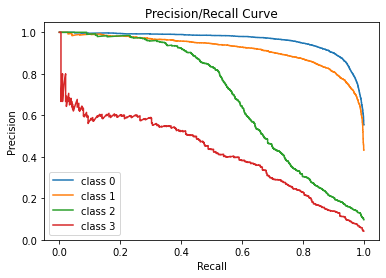

In [14]:
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [31]:
class ForwardDoctor:
    def __init__(self, model, module):
        self.model = model
        self.handle = module.register_forward_hook(self._modify_output)
        
    def _modify_output(self, module, inputs, outputs):
        channel_sum = outputs.sum(dim=(2,3), keepdim=True) #[batch_size, channel, 1, 1]
        channel_mean = channel_sum.mean(dim=1, keepdim=True) #[batch_size, 1, 1, 1]
        channel_weight = F.sigmoid(channel_sum-channel_mean) #[batch_size, channel, 1, 1]
        outputs = outputs * channel_weight
        return outputs
    
    def remove(self):
        self.handle.remove()

[INFO]: Validation report:
              precision    recall  f1-score   support

           0     0.9053    0.8901    0.8976      6522
           1     0.7933    0.9201    0.8520      4370
           2     0.8402    0.4987    0.6259      1149
           3     0.5498    0.3791    0.4488       393

    accuracy                         0.8483     12434
   macro avg     0.7721    0.6720    0.7061     12434
weighted avg     0.8487    0.8483    0.8423     12434




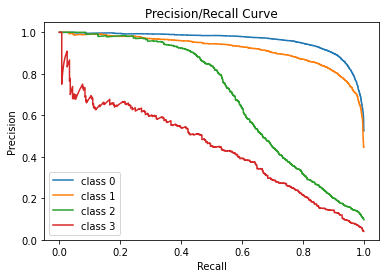

In [33]:
hook = ForwardDoctor(net, net.encoder.layer4[2].conv2)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

[INFO]: Validation report:
              precision    recall  f1-score   support

           0     0.8854    0.9154    0.9001      6522
           1     0.8316    0.8769    0.8536      4370
           2     0.7515    0.5422    0.6299      1149
           3     0.5630    0.3639    0.4420       393

    accuracy                         0.8499     12434
   macro avg     0.7579    0.6746    0.7064     12434
weighted avg     0.8439    0.8499    0.8443     12434




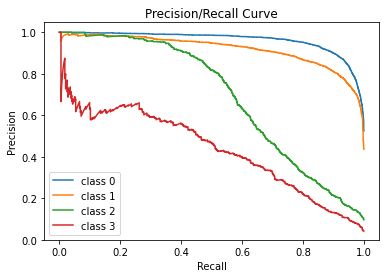

In [35]:
hook2 = ForwardDoctor(net, net.encoder.layer4[2].conv1)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

[INFO]: Validation report:
              precision    recall  f1-score   support

           0     0.8836    0.9042    0.8938      6522
           1     0.7952    0.9135    0.8503      4370
           2     0.9050    0.4064    0.5610      1149
           3     0.5670    0.3232    0.4117       393

    accuracy                         0.8431     12434
   macro avg     0.7877    0.6368    0.6792     12434
weighted avg     0.8445    0.8431    0.8325     12434




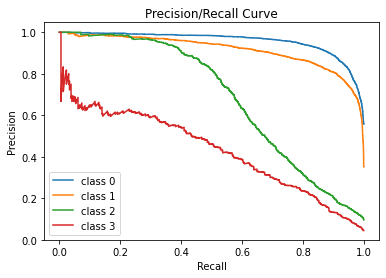

In [36]:
hook3 = ForwardDoctor(net, net.encoder.layer4[1].conv2)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

[INFO]: Validation report:
              precision    recall  f1-score   support

           0     0.7690    0.9627    0.8550      6522
           1     0.9254    0.5426    0.6841      4370
           2     0.5010    0.6240    0.5558      1149
           3     0.4783    0.3359    0.3946       393

    accuracy                         0.7640     12434
   macro avg     0.6684    0.6163    0.6224     12434
weighted avg     0.7900    0.7640    0.7528     12434




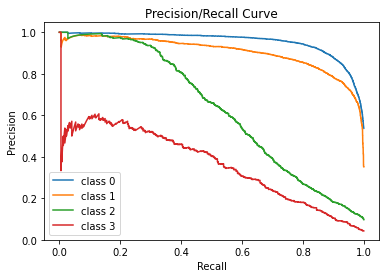

In [37]:
hook4 = ForwardDoctor(net, net.encoder.layer4[1].conv1)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

[INFO]: Validation report:
              precision    recall  f1-score   support

           0     0.8097    0.9264    0.8641      6522
           1     0.8517    0.7057    0.7719      4370
           2     0.6562    0.5300    0.5864      1149
           3     0.3972    0.4275    0.4118       393

    accuracy                         0.7964     12434
   macro avg     0.6787    0.6474    0.6585     12434
weighted avg     0.7972    0.7964    0.7917     12434




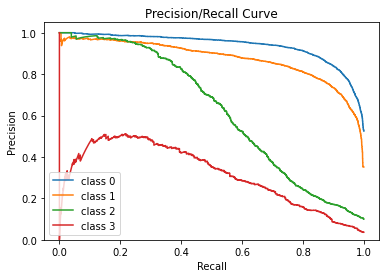

In [38]:
hook5 = ForwardDoctor(net, net.encoder.layer4[0].conv2)
hook6 = ForwardDoctor(net, net.encoder.layer4[0].conv1)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [41]:
hook.remove()
hook2.remove()
hook3.remove()
hook4.remove()
hook5.remove()
hook6.remove()

[INFO]: Validation report:
              precision    recall  f1-score   support

           0     0.9047    0.8911    0.8979      6522
           1     0.8071    0.9018    0.8518      4370
           2     0.7642    0.5387    0.6320      1149
           3     0.5016    0.4046    0.4479       393

    accuracy                         0.8470     12434
   macro avg     0.7444    0.6841    0.7074     12434
weighted avg     0.8447    0.8470    0.8429     12434




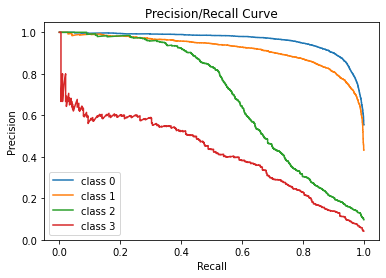

In [42]:
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

[INFO]: Validation report:
              precision    recall  f1-score   support

           0     0.8999    0.8977    0.8988      6522
           1     0.8194    0.8911    0.8538      4370
           2     0.7527    0.5405    0.6292      1149
           3     0.4929    0.4402    0.4651       393

    accuracy                         0.8479     12434
   macro avg     0.7412    0.6924    0.7117     12434
weighted avg     0.8452    0.8479    0.8444     12434




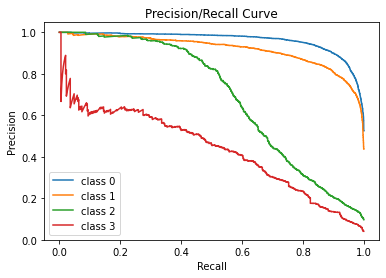

In [43]:
hook = ForwardDoctor(net, net.encoder.layer4[2].bn2)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

[INFO]: Validation report:
              precision    recall  f1-score   support

           0     0.8985    0.8987    0.8986      6522
           1     0.8192    0.8904    0.8533      4370
           2     0.7600    0.5318    0.6257      1149
           3     0.4846    0.4402    0.4613       393

    accuracy                         0.8474     12434
   macro avg     0.7406    0.6903    0.7097     12434
weighted avg     0.8447    0.8474    0.8436     12434




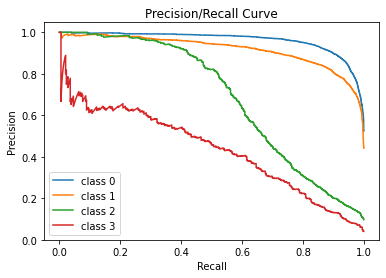

In [44]:
hook2 = ForwardDoctor(net, net.encoder.layer4[2].bn1)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

[INFO]: Validation report:
              precision    recall  f1-score   support

           0     0.9052    0.8960    0.9006      6522
           1     0.8131    0.9009    0.8548      4370
           2     0.7876    0.5292    0.6330      1149
           3     0.5165    0.4784    0.4967       393

    accuracy                         0.8507     12434
   macro avg     0.7556    0.7011    0.7213     12434
weighted avg     0.8497    0.8507    0.8470     12434




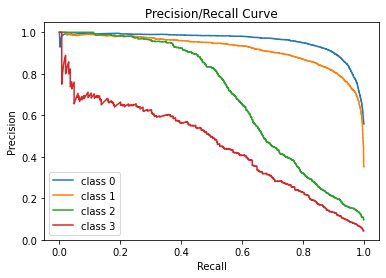

In [45]:
hook3 = ForwardDoctor(net, net.encoder.layer4[1].bn2)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

[INFO]: Validation report:
              precision    recall  f1-score   support

           0     0.9012    0.8977    0.8995      6522
           1     0.8098    0.9005    0.8527      4370
           2     0.8170    0.5013    0.6214      1149
           3     0.4933    0.4682    0.4804       393

    accuracy                         0.8485     12434
   macro avg     0.7553    0.6919    0.7135     12434
weighted avg     0.8484    0.8485    0.8441     12434




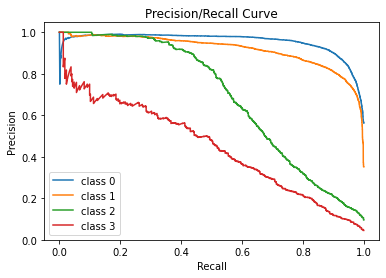

In [46]:
hook4 = ForwardDoctor(net, net.encoder.layer4[1].bn1)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

[INFO]: Validation report:
              precision    recall  f1-score   support

           0     0.9223    0.8494    0.8843      6522
           1     0.7604    0.9231    0.8339      4370
           2     0.8414    0.4526    0.5886      1149
           3     0.4266    0.5471    0.4794       393

    accuracy                         0.8291     12434
   macro avg     0.7377    0.6930    0.6965     12434
weighted avg     0.8422    0.8291    0.8265     12434




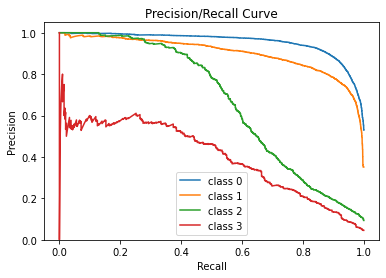

In [47]:
hook5 = ForwardDoctor(net, net.encoder.layer4[0].bn2)
hook6 = ForwardDoctor(net, net.encoder.layer4[0].bn1)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [48]:
hook.remove()
hook2.remove()
hook3.remove()
hook4.remove()
hook5.remove()
hook6.remove()

[INFO]: Validation report:
              precision    recall  f1-score   support

           0     0.9122    0.8842    0.8980      6522
           1     0.7953    0.9165    0.8516      4370
           2     0.7877    0.5231    0.6287      1149
           3     0.4952    0.3944    0.4391       393

    accuracy                         0.8467     12434
   macro avg     0.7476    0.6795    0.7043     12434
weighted avg     0.8464    0.8467    0.8423     12434




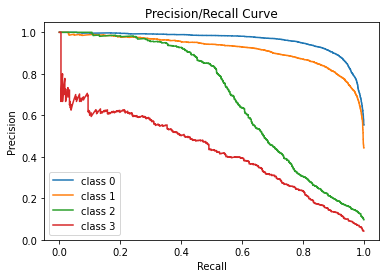

In [49]:
hook = ForwardDoctor(net, net.encoder.layer4[2].relu)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

[INFO]: Validation report:
              precision    recall  f1-score   support

           0     0.9106    0.8850    0.8976      6522
           1     0.7933    0.9169    0.8507      4370
           2     0.8081    0.5022    0.6194      1149
           3     0.4758    0.3995    0.4343       393

    accuracy                         0.8455     12434
   macro avg     0.7469    0.6759    0.7005     12434
weighted avg     0.8461    0.8455    0.8408     12434




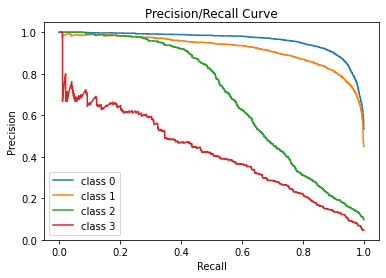

In [50]:
hook1 = ForwardDoctor(net, net.encoder.layer4[1].relu)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

[INFO]: Validation report:
              precision    recall  f1-score   support

           0     0.9158    0.8500    0.8817      6522
           1     0.7855    0.8998    0.8387      4370
           2     0.7152    0.5048    0.5918      1149
           3     0.3641    0.5216    0.4289       393

    accuracy                         0.8252     12434
   macro avg     0.6951    0.6941    0.6853     12434
weighted avg     0.8340    0.8252    0.8255     12434




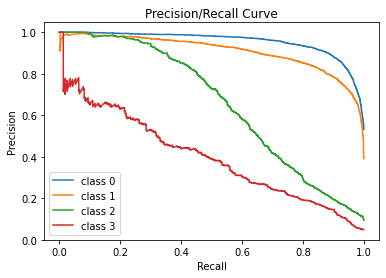

In [51]:
hook2 = ForwardDoctor(net, net.encoder.layer4[0].relu)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [52]:
hook.remove()
hook1.remove()
hook2.remove()

[INFO]: Validation report:
              precision    recall  f1-score   support

           0     0.9047    0.8911    0.8979      6522
           1     0.8071    0.9018    0.8518      4370
           2     0.7642    0.5387    0.6320      1149
           3     0.5016    0.4046    0.4479       393

    accuracy                         0.8470     12434
   macro avg     0.7444    0.6841    0.7074     12434
weighted avg     0.8447    0.8470    0.8429     12434




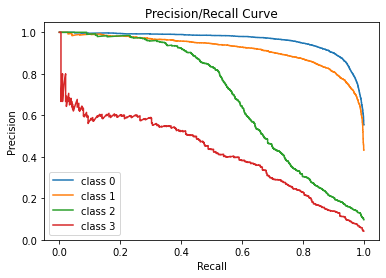

In [53]:
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [121]:
flag = False
for n, m in net.named_modules():
#     if not flag:
#         flag = True
#         continue
    print(n)


encoder
encoder.conv1
encoder.bn1
encoder.relu
encoder.maxpool
encoder.layer1
encoder.layer1.0
encoder.layer1.0.conv1
encoder.layer1.0.bn1
encoder.layer1.0.relu
encoder.layer1.0.conv2
encoder.layer1.0.bn2
encoder.layer1.1
encoder.layer1.1.conv1
encoder.layer1.1.bn1
encoder.layer1.1.relu
encoder.layer1.1.conv2
encoder.layer1.1.bn2
encoder.layer1.2
encoder.layer1.2.conv1
encoder.layer1.2.bn1
encoder.layer1.2.relu
encoder.layer1.2.conv2
encoder.layer1.2.bn2
encoder.layer2
encoder.layer2.0
encoder.layer2.0.conv1
encoder.layer2.0.bn1
encoder.layer2.0.relu
encoder.layer2.0.conv2
encoder.layer2.0.bn2
encoder.layer2.0.downsample
encoder.layer2.0.downsample.0
encoder.layer2.0.downsample.1
encoder.layer2.0.downsample.2
encoder.layer2.1
encoder.layer2.1.conv1
encoder.layer2.1.bn1
encoder.layer2.1.relu
encoder.layer2.1.conv2
encoder.layer2.1.bn2
encoder.layer2.2
encoder.layer2.2.conv1
encoder.layer2.2.bn1
encoder.layer2.2.relu
encoder.layer2.2.conv2
encoder.layer2.2.bn2
encoder.layer2.3
encoder.l

In [96]:
a = torch.arange(6).view(3, 2)
b = torch.tensor([0,1.,0])
c = torch.tensor([0,0,0.])
print(a)
print(b == c)
idx = torch.arange(3)[b == c]
print(idx)
print(a[b == c])
print(a[idx])
print(a[torch.tensor([0,1,2]), torch.tensor([1,0,1])])

tensor([[0, 1],
        [2, 3],
        [4, 5]])
tensor([ True, False,  True])
tensor([0, 2])
tensor([[0, 1],
        [4, 5]])
tensor([[0, 1],
        [4, 5]])
tensor([1, 2, 5])


In [99]:
a = torch.arange(6)
b = torch.tensor([0,1,0,1,0,0])
c = torch.tensor([0,1,0,1,0,0])
print(a[torch.bitwise_and(b == c,b == 1)])

tensor([1, 3])


In [114]:
a = torch.arange(6).view(2, 3).float()
print(torch.linalg.norm(a, dim=1))

tensor([2.23607, 7.07107])


In [123]:
a = torch.arange(6)
b = torch.tensor([0,1,0,1,0,0])
print(a[b==2].size(0))

0


In [125]:
print(torch.log(torch.tensor(0)))

tensor(-inf)


In [ ]:
class AdNoise:
    def __init__(self, model, module):
        self.model = model
        self.handle = module.register_forward_hook(self._get_output)
        
    def _get_output(self, module, inputs, outputs):
        self.outputs = outputs
        outputs += torch.randn(outputs.shape).to(outputs.device)
    
    def grads(self, outputs, retain_graph=True, create_graph=True):
        grads = torch.autograd.grad(outputs=outputs, inputs=self.outputs, retain_graph=retain_graph, create_graph=create_graph)
        self.model.zero_grad()
        return grads[0]
    
    def remove(self):
        self.handle.remove()
        
class Mul2:
    def __init__(self, model, module):
        self.model = model
        self.handle = module.register_forward_hook(self._get_output)
        
    def _get_output(self, module, inputs, outputs):
        self.outputs = outputs
        outputs *= 2
    
    def grads(self, outputs, retain_graph=True, create_graph=True):
        grads = torch.autograd.grad(outputs=outputs, inputs=self.outputs, retain_graph=retain_graph, create_graph=create_graph)
        self.model.zero_grad()
        return grads[0]
    
    def remove(self):
        self.handle.remove()

In [ ]:
class Test(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.conv2 = nn.Conv2d(10, 1, 3)
        nn.init.constant_(self.conv1.weight, 1)
        nn.init.constant_(self.conv1.weight, 0)
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.exp(x)
        x = self.conv2(x)
        return x
    
test = Test()

In [ ]:
h2 = Mul2(test, test.conv1)

In [ ]:
h2.remove()

In [ ]:
hn = AdNoise(test, test.conv1)

In [ ]:
hn.remove()

In [ ]:
a = torch.ones(2,3,6,6)
res = test(a)
ressum = res.sum()
print(res)
print(ressum)

In [ ]:
print(h2.outputs)
print(h2.grads(ressum))

In [ ]:
print(h2.outputs)
print(h2.grads(ressum))

In [ ]:
print(hn.outputs)
print(hn.grads(ressum))

In [ ]:
t = torch.ones(2,2)
print(id(t))

In [ ]:
t += 1
print(id(t))

In [ ]:
t = t+1
print(id(t))

In [ ]:
a = 1
b = a
print(id(a), id(b))

In [4]:
def bad_append(new_item, a_list=[]):
 
    a_list.append(new_item)
 
    return a_list

In [11]:
print(bad_append(1))

[1, 1, 1, 1, 1]


In [ ]:
a = (1,2)
a[0] = 3

In [ ]:
class Test():
    a = None
    
def fun(x):
    x = Test()
    x.a = 7

In [ ]:
t, k = Test(), Test()
t.a = 1
k.a = 2
p = t
print(p.a, t.a, k.a)
print(id(p), id(t), id(k))
p = k
print(p.a, t.a, k.a)
print(id(p), id(t), id(k))